# GETTING 3 SEPARATE DF'S TO LATER COMBINE INTO 1



Overview Steps of Following Work:

1. Top 5 Short Haul Dataset: df_top5short_final
2. Top 5 Medium Haul Dataset: df_top5med_final
3. Top 5 Long Haul Dataset: df_top5long_final
4. Combined Total Dataset: df_all_final
5. Add Columns defining Short, Med, Long Haul
6. Plot distribution of flight carriers
7. Plot distribution of haul types
8. Plot Airfare Distribution in short-haul Markets
9. Plot Airfare Distribution in medium-haul Markets
10. Plot Airfare Distribution in long-haul Markets

In [2]:
#Import Packages
import snowflake.connector
import pandas as pd

# 1. TOP5 SHORT HAUL

### Distribution of Data between the years and CXR

In [2]:
##CHECKING DISTRIBUTION OF DATA BY YEAR AND CXR
    
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
     WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT <=3 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT <= 3 ORDER BY DURATION_HRSINT DESC
        )
    SELECT YEAR, CXR, COUNT(*) 
    FROM df3 
    GROUP BY YEAR , CXR
    ORDER BY max(QTS) ASC
    ;
 
    """)

    df_top5short_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [10]:
df_top5short_final

,YEAR,CXR,COUNT(*)
0,2020,AA,535211
1,2020,DL,556223
2,2020,B6,18313
3,2020,UA,397145
4,2021,B6,262726
5,2021,AA,4570518
6,2021,DL,3340081
7,2021,UA,2950054
8,2022,DL,3816470
9,2022,AA,7300294


### Finding Top 5 Short Haul Flight Markets

In [3]:
# DATA GRAIN:
#expedia
#date: June 2021-June 2022
#fare_type: Economy and ECONOMY
#departure_stops = 0
#duration_hrsint <=3
    
    #        SELECT * FROM df2 WHERE ((MONTH >= 4 AND YEAR >= 2021) OR (MONTH <= 3 AND YEAR <= 2022)) 
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
    WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT <=3 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT <= 3 ORDER BY DURATION_HRSINT DESC
        ),
    df4 as(
        SELECT * FROM df2 WHERE (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL')
    )
     SELECT MARKET,COUNT(MARKET) AS `value_occurrence` 
            FROM df4
            GROUP BY MARKET
            ORDER BY `value_occurrence` DESC
            LIMIT 5
    
    ;
    
 
    """)

    df_top5short_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [12]:
df_top5short_final

,MARKET,`VALUE_OCCURRENCE`
0,DFWORD,1887178
1,ORDDFW,1886428
2,ORDIAH,1342669
3,IAHORD,1305633
4,DFWATL,1274908


### Final Data Grain Top 5 Short Haul Dataset with All Carriers

In [3]:
# DATA GRAIN:
#expedia
#date: April 2021-March 2022
#fare_type: Economy and ECONOMY
#departure_stops =1
#duration_hrsint <=3
#Top 3 CXR: AA, UA, DW
#TOP 5 SHORT FLIGHTS
# 0	DFWORD	1644927
# 1	ORDDFW	1638829
# 2	ORDIAH	1154915
# 3	IAHORD	1125903
# 4	DFWATL	1091099
    
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
    WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT <=3 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT <= 3 ORDER BY DURATION_HRSINT DESC
        )
    SELECT * FROM df3
        WHERE  (MARKET = 'DFWORD' 
            OR MARKET = 'ORDDFW' 
            OR MARKET = 'ORDIAH' 
            OR MARKET = 'IAHORD' 
            OR MARKET = 'DFWATL')
    ;
    
 
    """)

    df_top5short_final1 = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)

In [4]:
df_top5short_final1

,MARKET,SITE,CXR,QTS,QL2_QTS,DEPARTURE_DATE,QL2_DDATE,DEPARTURE_STOPS,FARE_TYPE,FARE,FLIGHT_NUMBER,DEPARTURE_TIME,ROUTE,YEAR_MONTH,DURATION_FLIGHT,MONTH,YEAR,DURATION_HRSINT
0,IAHORD,EXP,UA,2022-01-18 23:08:00,7322,2022-01-23,7327,0,ECONOMY,227.6,503,09:55,09:55 - IAH :: 12:40 - ORD,IAHORD20221,2:45,1,2022,3.0
1,DFWORD,EXP,UA,2022-01-18 23:08:00,7322,2022-01-29,7333,0,ECONOMY,88.6,6099,10:05,10:05 - DFW :: 12:38 - ORD,DFWORD20221,2:33,1,2022,3.0
2,DFWORD,EXP,UA,2022-01-18 23:08:00,7322,2022-01-29,7333,0,ECONOMY,138.6,4762,16:22,16:22 - DFW :: 18:55 - ORD,DFWORD20221,2:33,1,2022,3.0
3,DFWORD,EXP,AA,2022-01-18 23:08:00,7322,2022-01-29,7333,0,ECONOMY,200.6,1106,16:51,16:51 - DFW :: 19:24 - ORD,DFWORD20221,2:33,1,2022,3.0
4,IAHORD,EXP,AA,2022-01-18 23:08:00,7322,2022-02-03,7338,0,ECONOMY,83.6,1224,07:00,07:00 - IAH :: 09:35 - ORD,IAHORD20222,2:35,1,2022,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196417,DFWATL,EXP,DL,2022-03-25 12:09:00,7388,2022-04-24,7418,0,ECONOMY,278.6,32,12:00,12:00 - DFW :: 14:59 - ATL,DFWATL20224,1:59,3,2022,2.0
196418,DFWATL,EXP,AA,2022-03-25 12:09:00,7388,2022-04-11,7405,0,ECONOMY,193.6,980,10:20,10:20 - DFW :: 13:27 - ATL,DFWATL20224,2:07,3,2022,2.0
196419,DFWATL,EXP,DL,2022-03-25 12:09:00,7388,2022-04-11,7405,0,ECONOMY,228.6,1416,07:00,07:00 - DFW :: 10:08 - ATL,DFWATL20224,2:08,3,2022,2.0
196420,DFWATL,EXP,DL,2022-03-25 12:09:00,7388,2022-04-11,7405,0,ECONOMY,228.6,1420,08:20,08:20 - DFW :: 11:23 - ATL,DFWATL20224,2:03,3,2022,2.0


# 2. TOP 5 MED HAUL

### Distribution of data by year and CXR

In [15]:
##CHECKING DISTRIBUTION OF DATA BY YEAR and CXR
    
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
    
    
    WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 (DURATION_HRS_FLT >= 3 AND DURATION_HRS_FLT <=6)
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE (DURATION_HRSINT >= 3 AND DURATION_HRSINT <=6) ORDER BY DURATION_HRSINT DESC
        )
    SELECT YEAR, CXR, COUNT(*) 
    FROM df3 
    GROUP BY YEAR , CXR
    ORDER BY max(QTS) ASC
 
    """)

    df_top5med_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [16]:
df_top5med_final

,YEAR,CXR,COUNT(*)
0,2020,AA,166331
1,2020,DL,91103
2,2020,UA,158190
3,2020,B6,15519
4,2021,B6,155986
5,2021,AA,1129374
6,2021,DL,1171412
7,2021,UA,1469117
8,2022,B6,586378
9,2022,AA,1231084


### Finding top5 medium flight markets

In [17]:
# DATA GRAIN:
#expedia
#date: June 2021-June 2022
#fare_type: Economy and ECONOMY
#departure_stops = 0
#duration_hrsint <=3
#AA, UA, DL carriers only
    
    #        SELECT * FROM df2 WHERE ((MONTH >= 4 AND YEAR >= 2021) OR (MONTH <= 3 AND YEAR <= 2022)) 
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
     WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 (DURATION_HRS_FLT >= 3 AND DURATION_HRS_FLT <=6)
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE (DURATION_HRSINT >= 3 AND DURATION_HRSINT <=6) ORDER BY DURATION_HRSINT DESC
        ),
    df4 as(
        SELECT * FROM df3 WHERE (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL')
    )
     SELECT MARKET,COUNT(MARKET) AS `value_occurrence` 
            FROM df4
            GROUP BY MARKET
            ORDER BY `value_occurrence` DESC
            LIMIT 5
    
    ;
    
 
    """)

    df_top5med_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [18]:
df_top5med_final

,MARKET,`VALUE_OCCURRENCE`
0,ATLDEN,973832
1,DFWLAS,501174
2,IAHEWR,443639
3,EWRIAH,437063
4,LAXHNL,350643


### Final Data Grain of Top5 Med Haul Dataset with All Carriers

In [5]:
#Splitting the departure_date into new columns of year/month
    
# 0	ATLDEN	832415
# 1	DFWLAS	500648
# 2	EWRIAH	366561
# 3	IAHEWR	348468
# 4	LAXHNL	332463
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
    WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 (DURATION_HRS_FLT >= 3 AND DURATION_HRS_FLT <=6)
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE (DURATION_HRSINT >= 3 AND DURATION_HRSINT <=6) ORDER BY DURATION_HRSINT DESC
        )
    SELECT * FROM df3
        WHERE (MARKET = 'ATLDEN' 
            OR MARKET = 'DFWLAS' 
            OR MARKET = 'EWRIAH' 
            OR MARKET = 'IAHEWR' 
            OR MARKET = 'LAXHNL')
 
      ;
 
    """)

    df_top5med_final1 = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [6]:
df_top5med_final1

,MARKET,SITE,CXR,QTS,QL2_QTS,DEPARTURE_DATE,QL2_DDATE,DEPARTURE_STOPS,FARE_TYPE,FARE,FLIGHT_NUMBER,DEPARTURE_TIME,ROUTE,YEAR_MONTH,DURATION_FLIGHT,MONTH,YEAR,DURATION_HRSINT
0,LAXHNL,EXP,AA,2021-11-24 14:04:00,7267,2022-03-15,7378,0,ECONOMY,219.0,143,14:00,14:00 - LAX :: 16:37 - HNL,LAXHNL20223,5:37,11,2021,6.0
1,LAXHNL,EXP,AA,2021-11-24 14:04:00,7267,2021-12-31,7304,0,ECONOMY,194.0,143,14:45,14:45 - LAX :: 18:44 - HNL,LAXHNL202112,5:59,11,2021,6.0
2,LAXHNL,EXP,AA,2021-11-24 14:04:00,7267,2021-12-31,7304,0,ECONOMY,184.0,2205,18:30,18:30 - LAX :: 22:29 - HNL,LAXHNL202112,5:59,11,2021,6.0
3,LAXHNL,EXP,AA,2021-11-24 14:04:00,7267,2021-12-31,7304,0,ECONOMY,184.0,31,08:10,08:10 - LAX :: 12:11 - HNL,LAXHNL202112,6:01,11,2021,6.0
4,LAXHNL,EXP,AA,2021-11-24 14:04:00,7267,2022-03-22,7385,0,ECONOMY,219.0,143,14:00,14:00 - LAX :: 16:37 - HNL,LAXHNL20223,5:37,11,2021,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158245,ATLDEN,EXP,DL,2022-02-14 02:28:00,7349,2022-03-08,7371,0,ECONOMY,138.6,1231,12:44,12:44 - ATL :: 14:05 - DEN,ATLDEN20223,3:21,2,2022,3.0
158246,DFWLAS,EXP,AA,2022-02-14 02:28:00,7349,2022-02-22,7357,0,ECONOMY,259.6,1537,11:03,11:03 - DFW :: 12:10 - LAS,DFWLAS20222,3:07,2,2022,3.0
158247,DFWLAS,EXP,AA,2022-02-14 02:28:00,7349,2022-03-12,7375,0,ECONOMY,453.6,1537,10:45,10:45 - DFW :: 11:53 - LAS,DFWLAS20223,3:08,2,2022,3.0
158248,DFWLAS,EXP,AA,2022-02-14 02:28:00,7349,2022-02-25,7360,0,ECONOMY,342.6,1537,11:03,11:03 - DFW :: 12:10 - LAS,DFWLAS20222,3:07,2,2022,3.0


# 3. LONG HAUL

### Distribution of Data by Year and CXR

In [21]:
##CHECKING DISTRIBUTION OF DATA BY YEAR and CXR
    
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
      WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT >=5 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT >6 ORDER BY DURATION_HRSINT DESC
        )
    SELECT YEAR, CXR, COUNT(*) 
    FROM df3 
    GROUP BY YEAR , CXR
    ORDER BY max(QTS) ASC
    ;
 
    """)

    df_top5long_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)
    
    
   


In [22]:
df_top5long_final

,YEAR,CXR,COUNT(*)
0,2020,AA,10855
1,2020,DL,21430
2,2020,B6,1719
3,2020,UA,43897
4,2021,B6,16870
5,2021,UA,87021
6,2021,DL,90746
7,2021,AA,32566
8,2022,B6,41911
9,2022,DL,164031


Based off of this data, we are only going to be studying the top3 Carriers

### Final Top5 Long Haul Dataset with All Carriers

In [7]:
#Splitting the departure_date into new columns of year/month
# 0	EZEMIA	25349
# 1	JFKSFO	25128
# 2	MIAEZE	23597
# 3	LHRJFK	14548
# 4	MIAGRU	14450

try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
         WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT >=5 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT >6 ORDER BY DURATION_HRSINT DESC
        )
        
        SELECT * FROM df3
         WHERE (MARKET = 'EZEMIA' 
             OR MARKET = 'JFKSFO' 
             OR MARKET = 'MIAEZE' 
             OR MARKET = 'LHRJFK' 
             OR MARKET = 'MIAGRU')

     
      ;
 
    """)

    df_top5long_final1 = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [8]:
df_top5long_final1

,MARKET,SITE,CXR,QTS,QL2_QTS,DEPARTURE_DATE,QL2_DDATE,DEPARTURE_STOPS,FARE_TYPE,FARE,FLIGHT_NUMBER,DEPARTURE_TIME,ROUTE,YEAR_MONTH,DURATION_FLIGHT,MONTH,YEAR,DURATION_HRSINT
0,EZEMIA,EXP,AA,2021-12-23 08:39:00,7296,2021-12-24,7297,0,ECONOMY,1475.42,900,23:40,23:40 - EZE :: 06:50 - MIA,EZEMIA202112,9:10,12,2021,9.0
1,EZEMIA,EXP,DL,2021-12-23 04:11:00,7296,2022-01-29,7333,0,ECONOMY,2719.83,7598,23:30,23:30 - EZE :: 06:40 - MIA,EZEMIA20221,9:10,12,2021,9.0
2,EZEMIA,EXP,DL,2021-12-23 04:11:00,7296,2022-04-17,7411,0,ECONOMY,2719.83,7598,23:30,23:30 - EZE :: 07:40 - MIA,EZEMIA20224,9:10,12,2021,9.0
3,EZEMIA,EXP,DL,2021-12-23 04:11:00,7296,2022-03-18,7381,0,ECONOMY,2719.83,7598,23:30,23:30 - EZE :: 07:40 - MIA,EZEMIA20223,9:10,12,2021,9.0
4,EZEMIA,EXP,DL,2021-12-23 04:11:00,7296,2022-01-24,7328,0,ECONOMY,2693.08,7598,23:30,23:30 - EZE :: 06:40 - MIA,EZEMIA20221,9:10,12,2021,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4249,JFKSFO,EXP,DL,2021-12-04 10:10:00,7277,2022-01-03,7307,0,ECONOMY,608.40,343,08:18,08:18 - JFK :: 12:16 - SFO,JFKSFO20221,6:58,12,2021,7.0
4250,JFKSFO,EXP,AA,2021-12-04 10:10:00,7277,2022-01-03,7307,0,ECONOMY,844.40,9199,09:35,09:35 - JFK :: 13:31 - SFO,JFKSFO20221,6:56,12,2021,7.0
4251,JFKSFO,EXP,AA,2021-12-04 10:10:00,7277,2022-01-03,7307,0,ECONOMY,844.40,9354,19:34,19:34 - JFK :: 23:27 - SFO,JFKSFO20221,6:53,12,2021,7.0
4252,JFKSFO,EXP,AA,2021-12-07 13:41:00,7280,2021-12-10,7283,0,ECONOMY,148.40,76,07:00,07:00 - JFK :: 10:38 - SFO,JFKSFO202112,6:38,12,2021,7.0


### Combining all three datasets into 1

In [11]:
#Combining short, med, long haul dfs together
short_med1 = pd.concat([df_top5short_final1, df_top5med_final1], axis=0)
df_all1 = pd.concat([short_med1, df_top5long_final1], axis=0)

# 4. Code Needed to Copy to Get the Filtered Data Grain

### Short Haul DF

In [3]:
# DATA GRAIN:
#expedia
#date: April 2021-March 2022
#fare_type: Economy and ECONOMY
#departure_stops =1
#duration_hrsint <=3
#Top 3 CXR: AA, UA, DW
#TOP 5 SHORT FLIGHTS
# 0	DFWORD	1644927
# 1	ORDDFW	1638829
# 2	ORDIAH	1154915
# 3	IAHORD	1125903
# 4	DFWATL	1091099
    
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
    WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT <=3 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT <= 3 ORDER BY DURATION_HRSINT DESC
        )
    SELECT * FROM df3
        WHERE 
        (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL') 
        AND  (MARKET = 'DFWORD' 
            OR MARKET = 'ORDDFW' 
            OR MARKET = 'ORDIAH' 
            OR MARKET = 'IAHORD' 
            OR MARKET = 'DFWATL')
    ;
    
 
    """)

    df_top5short_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [4]:
df_top5short_final = df_top5short_final.dropna()

### Med Haul DF

In [5]:
#Splitting the departure_date into new columns of year/month
    
# 0	ATLDEN	832415
# 1	DFWLAS	500648
# 2	EWRIAH	366561
# 3	IAHEWR	348468
# 4	LAXHNL	332463
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
    WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 (DURATION_HRS_FLT >= 3 AND DURATION_HRS_FLT <=6)
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE (DURATION_HRSINT >= 3 AND DURATION_HRSINT <=6) ORDER BY DURATION_HRSINT DESC
        )
    SELECT * FROM df3
        WHERE 
        (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL') 
        AND  (MARKET = 'ATLDEN' 
            OR MARKET = 'DFWLAS' 
            OR MARKET = 'EWRIAH' 
            OR MARKET = 'IAHEWR' 
            OR MARKET = 'LAXHNL')
 
      ;
 
    """)

    df_top5med_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [6]:
df_top5med_final = df_top5med_final.dropna()

### Long Haul DF

In [7]:
#Splitting the departure_date into new columns of year/month
# 0	EZEMIA	25349
# 1	JFKSFO	25128
# 2	MIAEZE	23597
# 3	LHRJFK	14548
# 4	MIAGRU	14450

try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
         WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT >=5 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT >6 ORDER BY DURATION_HRSINT DESC
        )
        
        SELECT * FROM df3
         WHERE 
         (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL') 
            AND  (MARKET = 'EZEMIA' 
             OR MARKET = 'JFKSFO' 
             OR MARKET = 'MIAEZE' 
             OR MARKET = 'LHRJFK' 
             OR MARKET = 'MIAGRU')

     
      ;
 
    """)

    df_top5long_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [8]:
df_top5long_final = df_top5long_final.dropna()

### Combining all 3 dataset

In [9]:
#Combining short, med, long haul dfs together
short_med = pd.concat([df_top5short_final, df_top5med_final], axis=0)
df_all = pd.concat([short_med, df_top5long_final], axis=0)

### Adding Column HAUL_TYPE

In [10]:
df_all['HAUL_TYPE'] = df_all['DURATION_HRSINT'].apply(lambda x: 'short'if x <= 3 else ('medium' if (x >3 and x <=6) else 'long'))


In [13]:
df_all1 = df_all1.dropna()

In [46]:
df_all = df_all.dropna()

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

# visual_overview = c 
# #Count of flights v/s pandemic
# plt.figure(figsize = (15, 10))
# plt.title('Count of flights with  Pandemic time')
# colors = sns.color_palette('bright')[0:5]
# plt.pie(x= 'Pandemic', data =visual_overview)

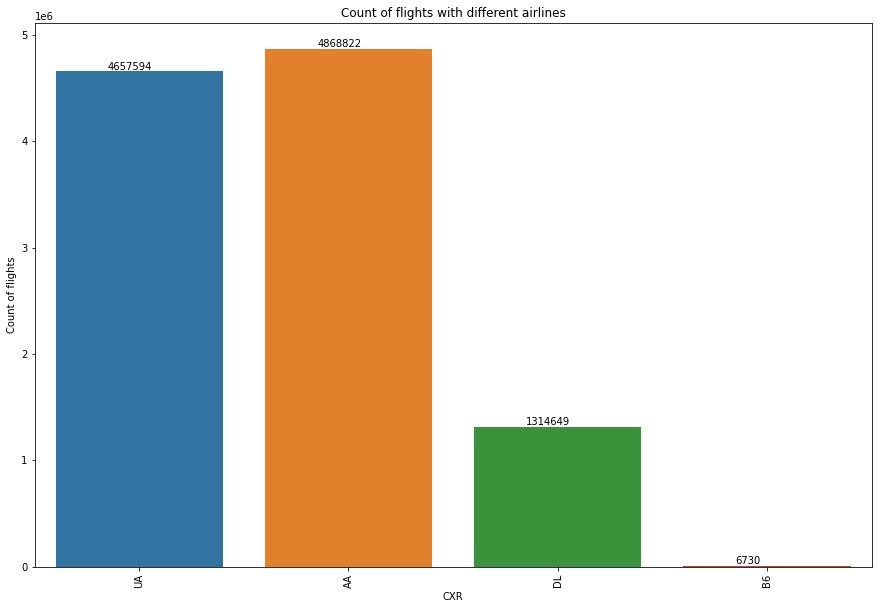

In [16]:
#Count of flights v/s Airline
plt.figure(figsize = (15, 10))
plt.title('Count of flights with different airlines')
ax=sns.countplot(x = 'CXR', data =df_all1)
plt.xlabel('CXR')
plt.ylabel('Count of flights')
plt.xticks(rotation = 90)
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va='bottom',
                    color= 'black')

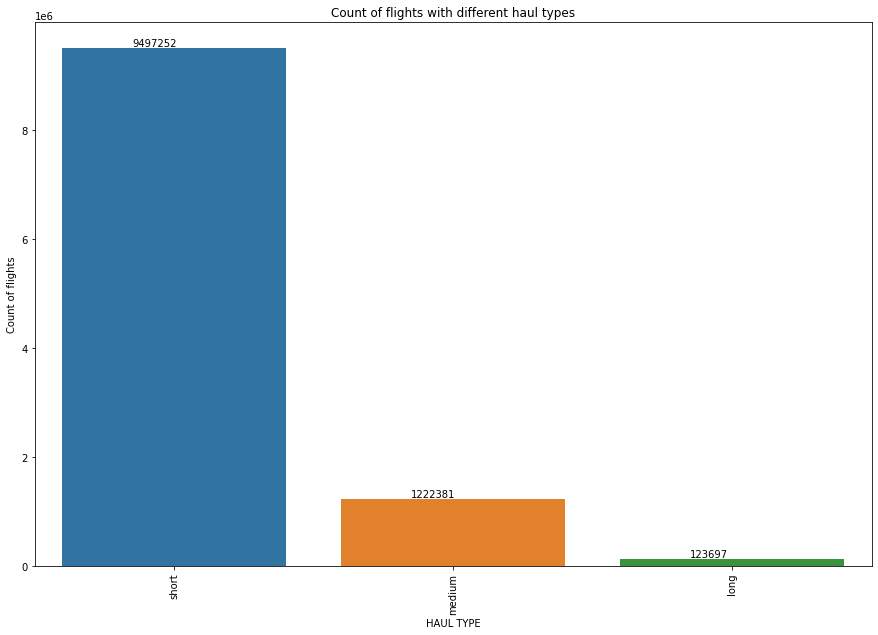

In [33]:
#Count of flights v/s Haul types
plt.figure(figsize = (15, 10))
plt.title('Count of flights with different haul types')
ax=sns.countplot(x = 'HAUL_TYPE', data =df_all)
plt.xlabel('HAUL TYPE')
plt.ylabel('Count of flights')
plt.xticks(rotation = 90)
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va='bottom',
                    color= 'black')

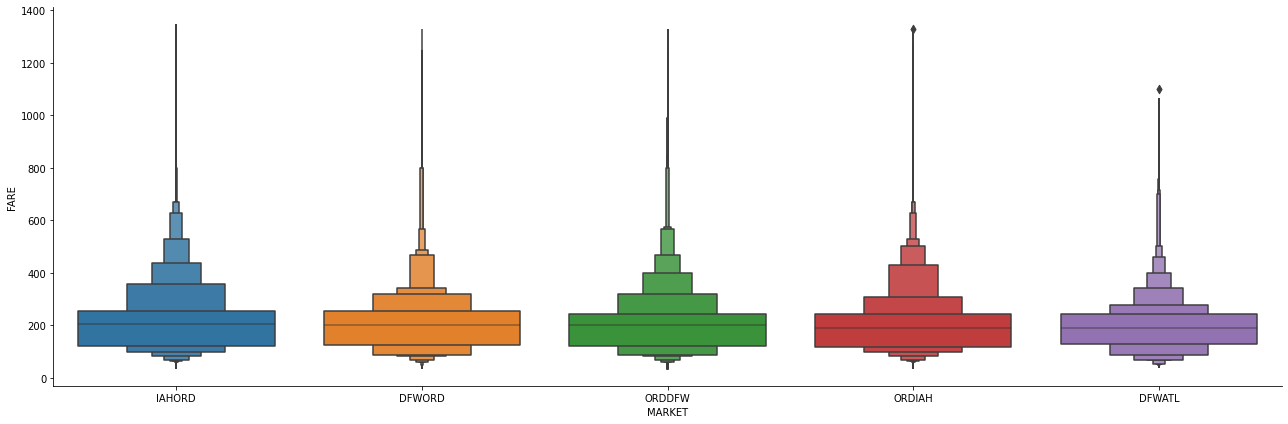

In [8]:
sns.catplot(y='FARE',x='MARKET',data= df_top5short_final.sort_values('FARE',ascending=False),kind="boxen",height=6, aspect=3)
plt.show()

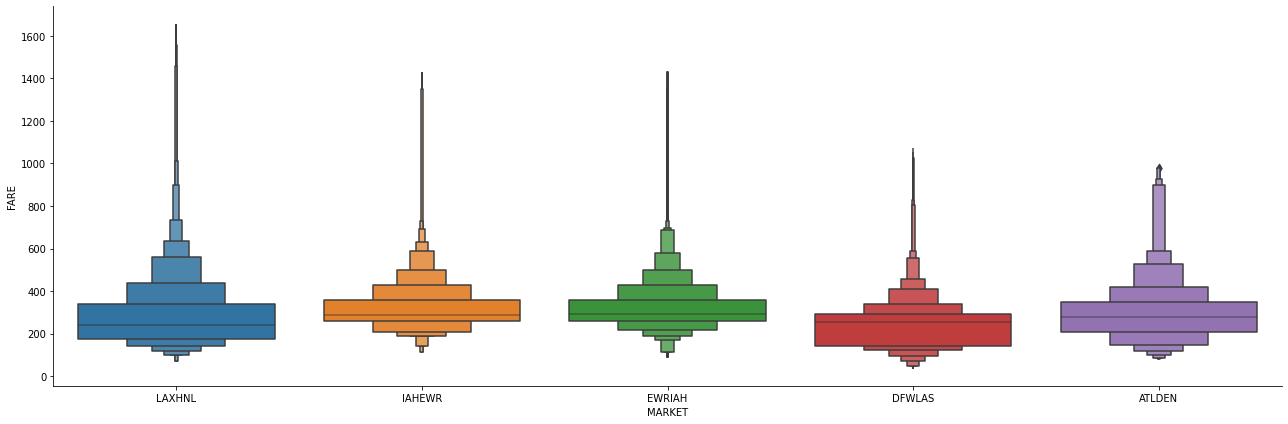

In [22]:
sns.catplot(y='FARE',x='MARKET',data= df_top5med_final.sort_values('FARE',ascending=False),kind="boxen",height=6, aspect=3)
plt.show()

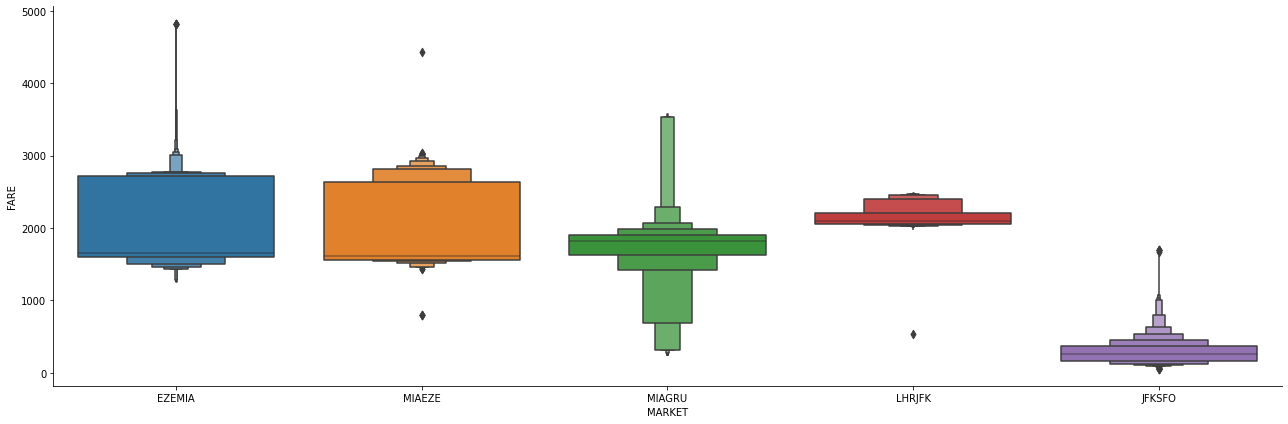

In [25]:
sns.catplot(y='FARE',x='MARKET',data= df_top5long_final.sort_values('FARE',ascending=False),kind="boxen",height=6, aspect=3)
plt.show()